In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


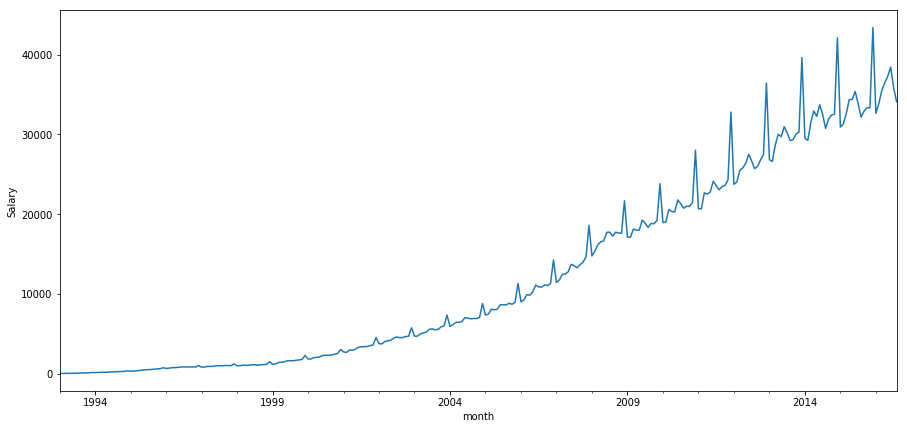

In [2]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.columns = ['Salary']
plt.figure(figsize(15,7))
data.Salary.plot()
plt.ylabel('Salary')
pylab.show()

У ряда есть явный тренд и у него разная дисперсия. Проведем формальную проверку + STL разложение

Критерий Дики-Фуллера: p=0.991850


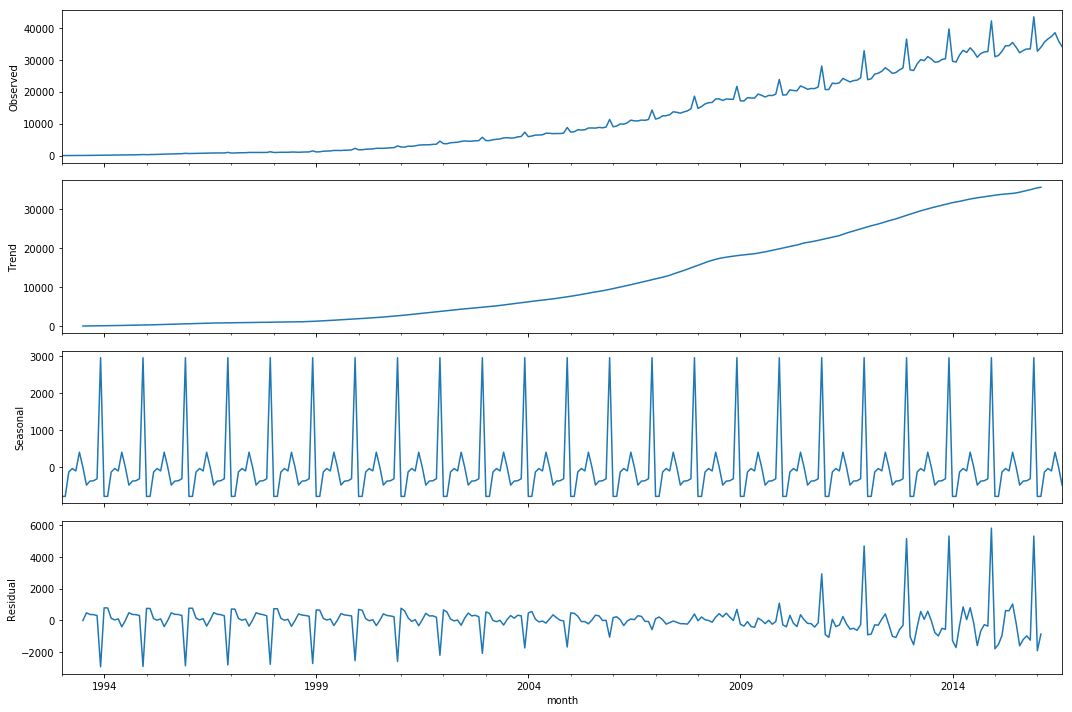

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.Salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Salary)[1])

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


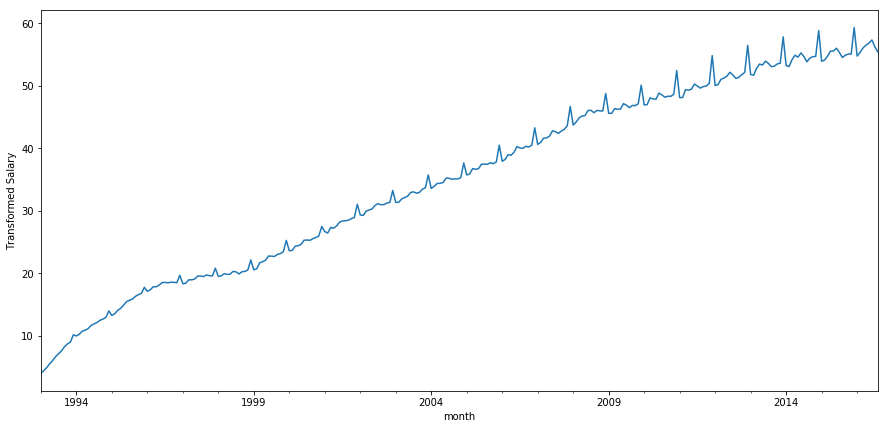

In [4]:
data['Salary_box'], lmbda = stats.boxcox(data.Salary)
plt.figure(figsize(15,7))
data.Salary_box.plot()
plt.ylabel(u'Transformed Salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Salary_box)[1])
plt.show()

У нас есть выраженная сезонность и тренд. Пробуем сделать диффиренцирование на сезонность

Критерий Дики-Фуллера: p=0.014697


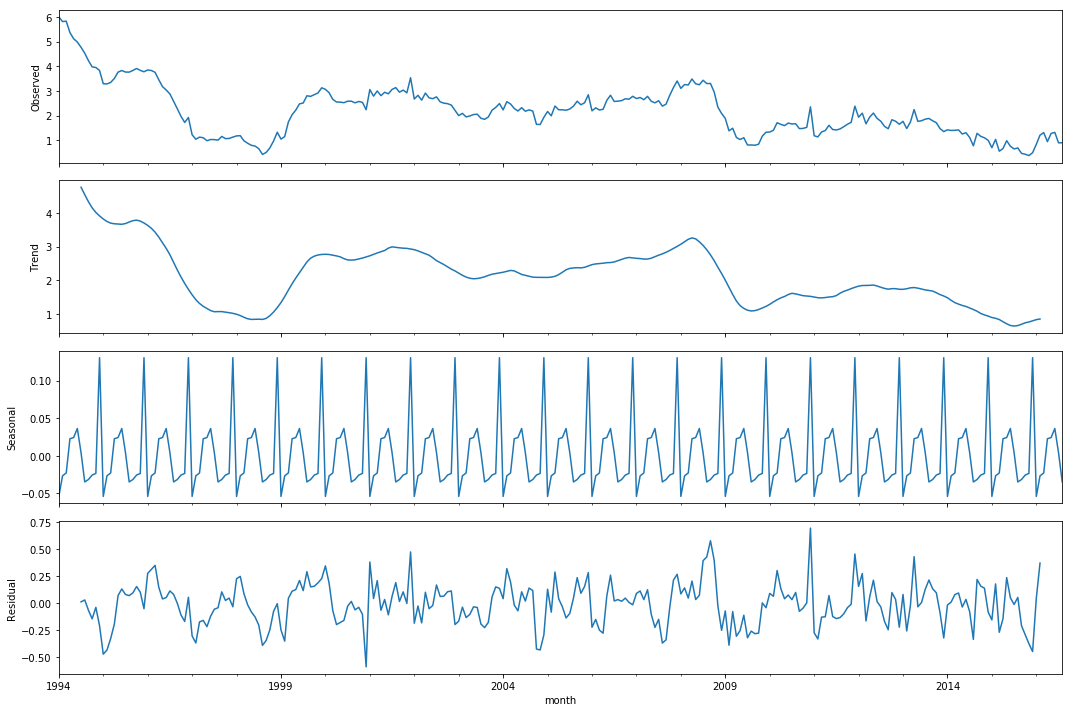

In [5]:
data['Salary_box_diff'] = data.Salary_box - data.Salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.Salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Salary_box_diff[12:])[1])
plt.show()

Хотя гипотеза нестационарности отвергается критерием Дики-Фуллера, тренд все еще есть. Нужно делать дифференцирование. 

Критерий Дики-Фуллера: p=0.000000


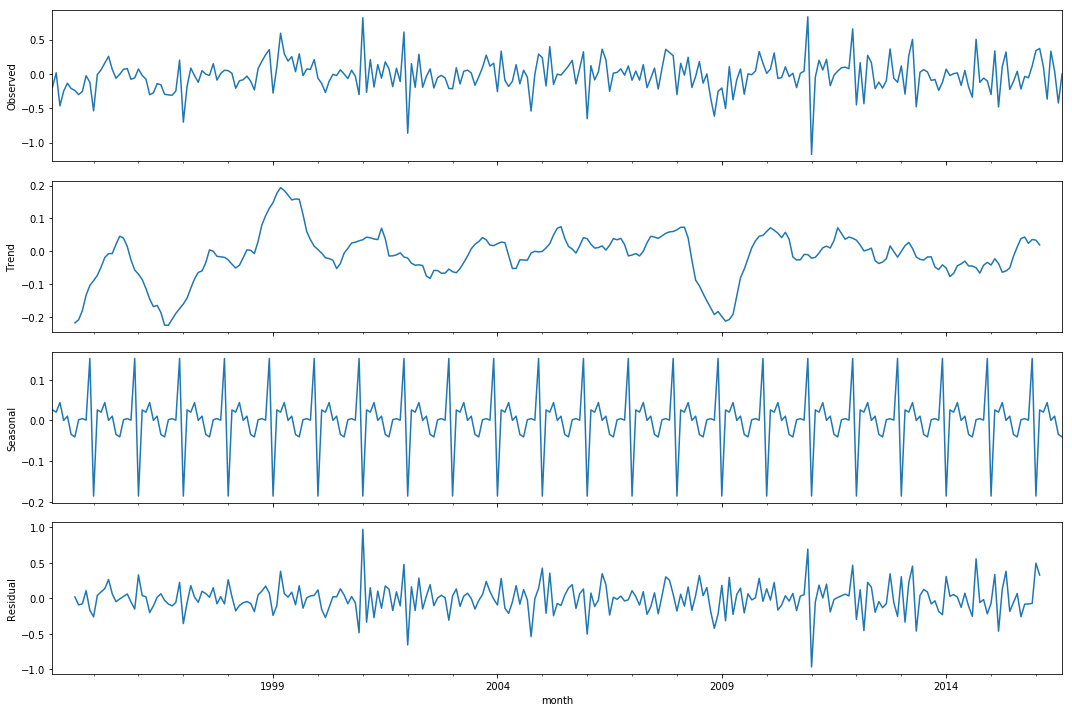

In [6]:
data['Salary_box_diff2'] = data.Salary_box_diff - data.Salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.Salary_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Salary_box_diff2[13:])[1])
plt.show()

Можно проверить как выгледит ряд при другом порядке диффиринцирования.

Критерий Дики-Фуллера: p=0.014396


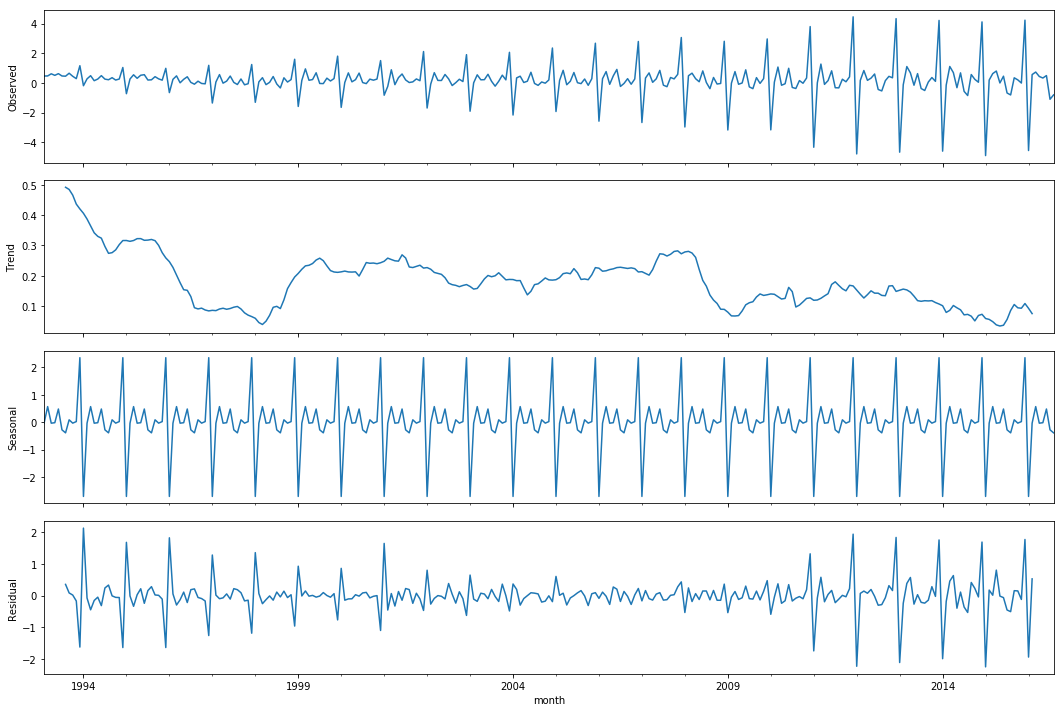

In [7]:
data['Salary_box_diff_invert'] = data.Salary_box - data.Salary_box.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.Salary_box_diff_invert[1:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Salary_box_diff_invert[1:])[1])
plt.show()

Критерий Дики-Фуллера: p=0.000000


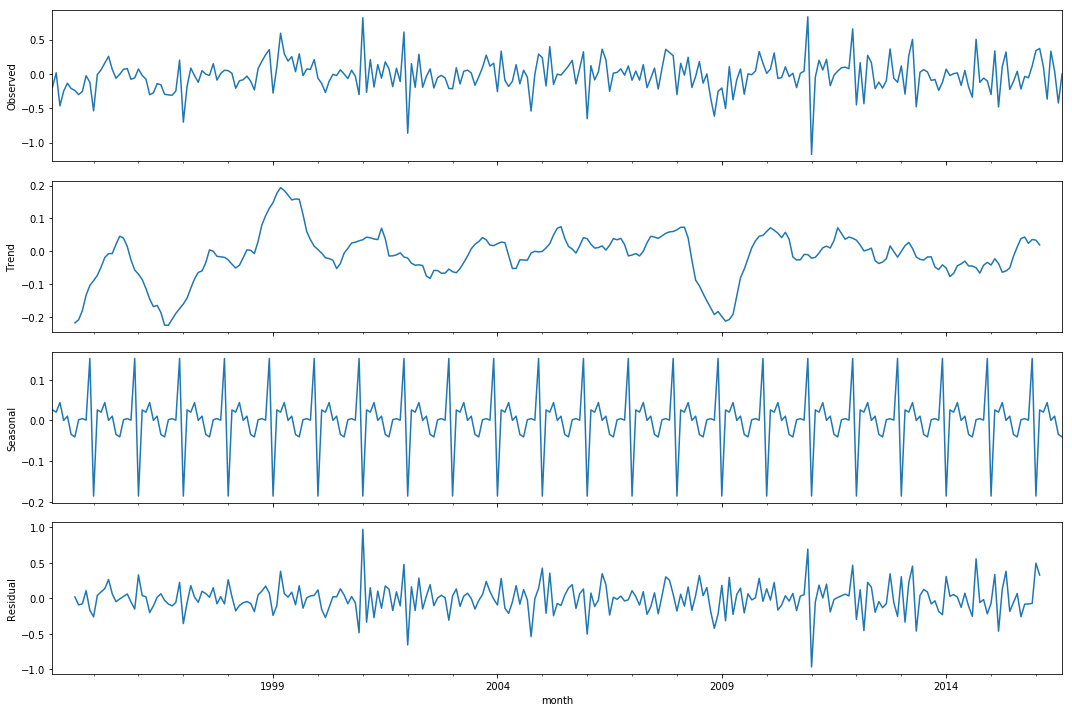

In [8]:
data['Salary_box_diff_invert2'] = data.Salary_box_diff_invert - data.Salary_box_diff_invert.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.Salary_box_diff_invert2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Salary_box_diff_invert2[13:])[1])
plt.show()

Оба варианта приводят к стационарным рядам и можно начинать подбирать начальные параметры.

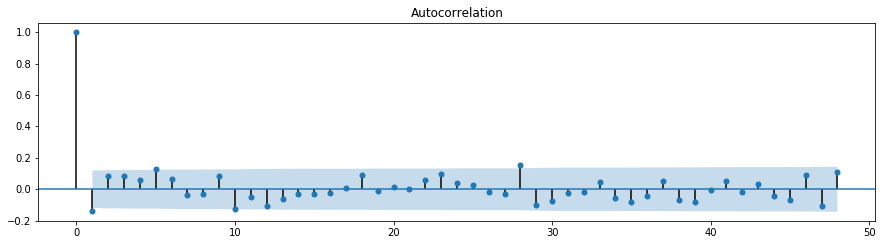

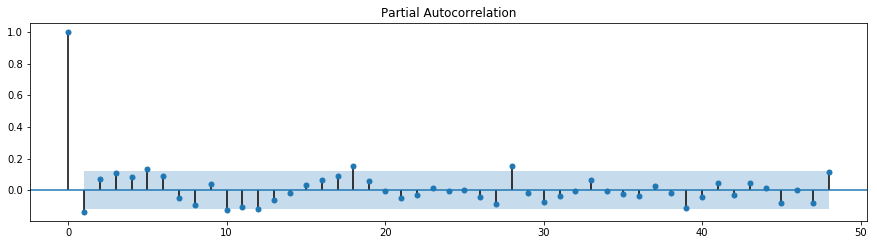

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.Salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.Salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0(последний значинимы сезонный лаг / 12), q=6(последни значиммый не сезонный лаг, но не сильно большой),
по частичной автокоррекции подбираем P=1(последний значинимы сезонный лаг / 12), p=6(последни значиммый не сезонный лаг, но не сильно большой)

In [10]:
ps = range(0, 7)
d=1
qs = range(0,7)
Ps = range(0, 2)
D=1
Qs = range(0,2)  # Т.к. мы будем подбирать лучшую модель по гиперпараметрам, позволим немного расширить варианты подбора задав Q=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

196

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.Salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print 'wrong parameters (LinAlgError):', param
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 0, 1))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 1, 1))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 0, 1))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 2, 1, 1))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4, 0, 1))
('wrong parameters:', (4, 4, 1, 0))
('wrong parameters:', (4, 4, 1, 1))
('wrong parameters:', (5, 2, 0, 0))
('wrong parameters:', (5, 2, 0, 1))
('wrong parameters:', (5, 2,

In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(10))

       parameters        aic
125  (5, 5, 1, 0) -25.962897
124  (5, 5, 0, 1) -25.409046
126  (5, 5, 1, 1) -24.453933
145  (6, 5, 1, 0) -23.963923
144  (6, 5, 0, 1) -23.447887
123  (5, 5, 0, 0) -23.154514
146  (6, 5, 1, 1) -22.730039
149  (6, 6, 1, 0) -21.464638
143  (6, 5, 0, 0) -21.049994
148  (6, 6, 0, 1) -20.323547


Минимальный AIC мы получаем для модели с параметрами (5,5,1,0). Модели с более маленькими коофициентами имеют существенную разницу в  AIC, как лучшую модель берем именно ее. 
Посмотрим на параметры лучшей модели

In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         Salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.981
Date:                            Thu, 17 Aug 2017   AIC                            -25.963
Time:                                    18:37:59   BIC                             17.825
Sample:                                01-01-1993   HQIC                            -8.408
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0334     12.011      0.003      0.998     -23.507      23.574
ar.L2          0.0091      8.206   

Критерий Стьюдента: p=0.169361
Критерий Дики-Фуллера: p=0.000000


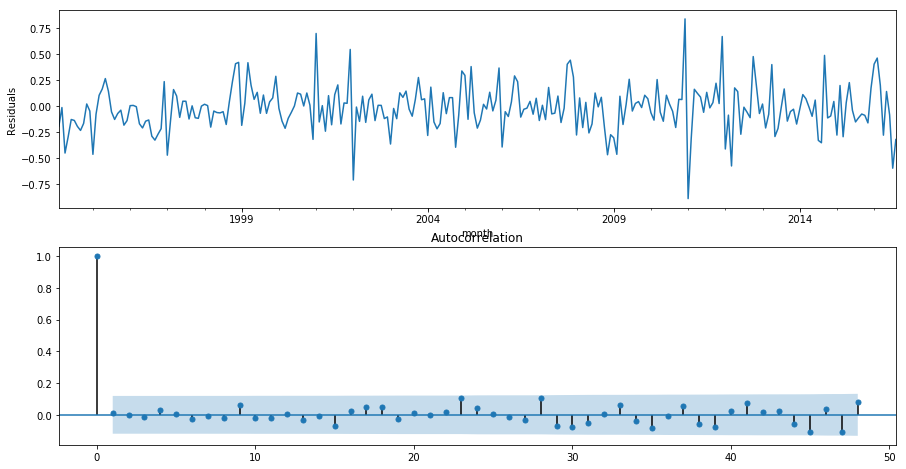

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

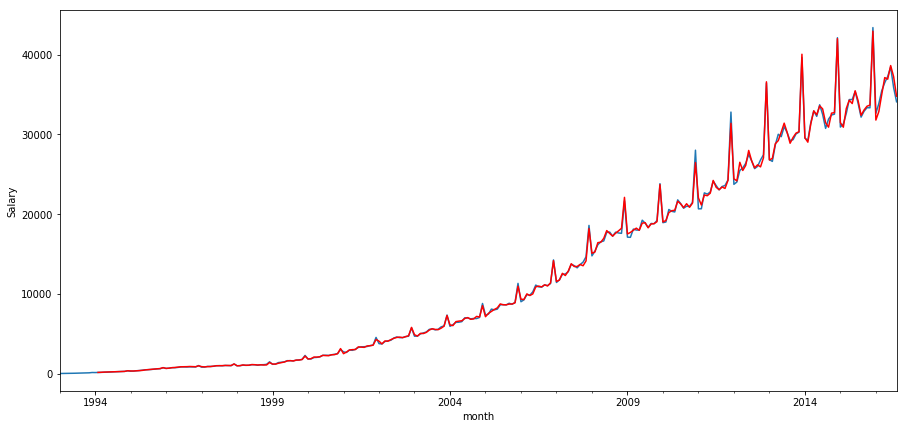

In [15]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.Salary.plot()
data.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

Визуально модель описывает данные хорошо.

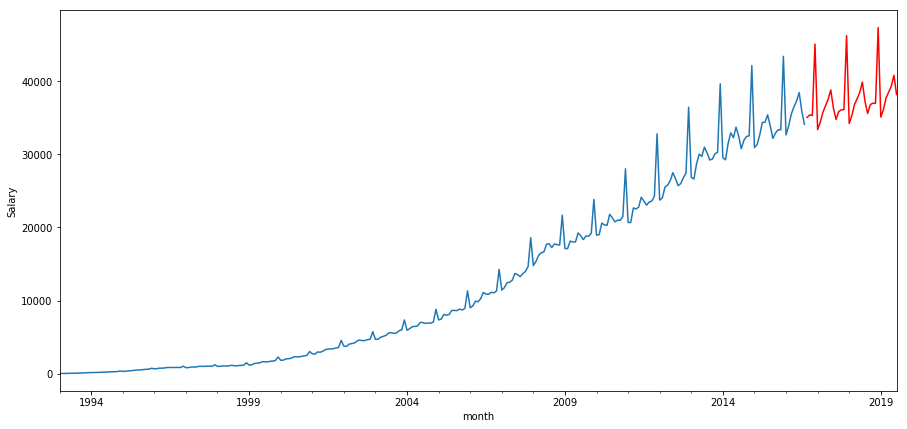

In [16]:
data2 = data[['Salary']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=284+36), lmbda)

plt.figure(figsize(15,7))
data.Salary.plot()
data2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

Визуально модель делает достаточно хороший прогноз.